### Scientific computing - Project 2
Jeppe Peder Grejs Petersen

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Project2_examplematrices
import pandas as pd
import chladni_show as fun
import myfuncs
from joblib import Parallel, delayed


def back_sub(U,y):
    rows,cols = U.shape
    x = np.zeros_like(y)
    for j in range(cols-1, -1, -1):  # from last column to
        #the first, starting to the right
        if U[j,j] == 0:
            raise ValueError("Matrix is singular!")
        sum_ = 0
        for i in range(j+1, cols): ## going from the diag to the right
            sum_ += U[j, i] * x[i]
  
        x[j] = (y[j] - sum_)/U[j,j]

    return x


def householder_QR_slow(A):
    AAA = A.astype(float).copy()
    m, n = (AAA.shape)
    Q = np.eye(m)

    for k in range(min(m, n)):
        u_k = AAA[k:, k]
        alpha = - np.sign(AAA[k, k]) * np.linalg.norm(AAA[k:, k]) 
         ## take the sign of the k element in a-vector, 
         # and take the norm of the a vecotr
        e_k = np.zeros_like(u_k)
        e_k[0] = 1.0 ## create unit vector
    
        v_k = u_k - alpha * e_k 
        b_k = v_k.T @ v_k ## compute legnth of householder vector
        if b_k == 0:
            continue

        for j in range(k, n):
            y_j = v_k @ AAA[k:, j] 
            AAA[k:, j] -= 2 * v_k * y_j / b_k   
            ## apply the householder tranformation 
            # to the rows to the right.  Operating from the left

        H = np.eye(m)
        H[k:, k:] -= 2 * np.outer(v_k, v_k) / b_k 
        # create the full householder matrix

        Q = Q @ H 
        ## operationg from the right, following page 124 in the book
          
    R = AAA.copy()
    return Q, R


def least_squares_slow(A,b):
    Q,R = householder_QR_slow(A.copy())
    b_col = b.reshape(-1,1) 
    y = Q.T @ b_col
    x = back_sub(R, y)
    return x



a (1)

Below the gershorgin algorithm i created, following p.164. A function to plot the true eigenvalues, to see if they lie within circle is also created

In [192]:
def gershgorin(A):
    rows,cols = A.shape
    if rows != cols:
        raise ValueError("rows not equal to column")
    M = A.copy()
    centeres = np.diag(M)
    zeye = abs(np.eye(rows) - np.ones((rows,rows)))
    ## creating a matrix 
    #to set diag to zero, to do the row sum of the non-diag
    radii = np.sum(abs(M*zeye), axis = 1)
    return centeres, radii

def plot_gershgorin(A):
    eigenvals, _ = np.linalg.eig(A)
    centers, radii = gershgorin(A)
    fig, ax = plt.subplots()
    colors = plt.cm.tab20(np.linspace(0, 1, len(eigenvals)))

    for i, eig in enumerate(eigenvals):
        ax.scatter(eig, 0, label = f'True_val: {str(np.round(eig,2))}', color =colors[i] )
        cir = plt.Circle((centers[i],0), radii[i], fill = False, color = colors[i])
        ax.add_patch(cir)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.tick_params(axis='x', rotation=45)
    ax.set_aspect('equal')

a(2)

The K matrix is loaded, the centers and radiis are calculated and put into the table below.

,True eig.,Center,Radii
0,151362.666488,129292.219206,42231.646726
1,93999.614129,103041.439420,56927.518940
2,52766.288758,64967.578727,31160.670887
3,50430.027654,43612.411909,18532.348737
4,36152.369975,36273.751516,7870.516137
5,32779.071084,37990.099373,17854.702613
6,22590.198520,24166.971120,15414.716667
7,13338.622299,11651.158690,2512.041395
8,11485.212834,13865.080461,5502.969527
9,5560.881198,5600.547665,1195.283294


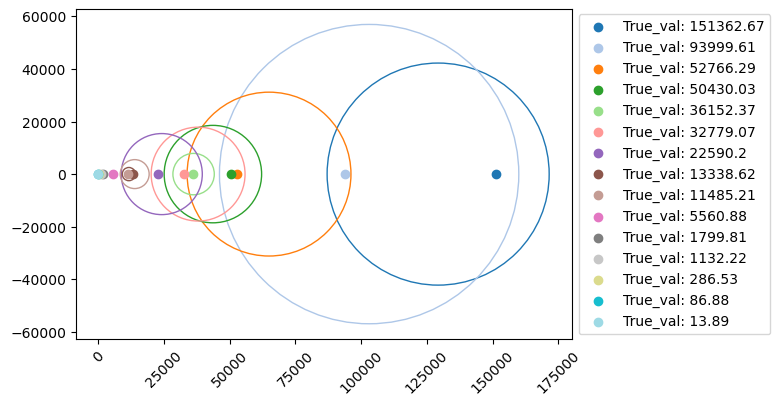

In [195]:
K = np.load('Chladni-Kmat.npy')
true_eig = np.linalg.eig(K)[0]
center, radii = gershgorin(K)
pd_dict = {
    "True eig.": true_eig,
    "Center": center, 
    "Radii": radii,
}
df_pd = pd.DataFrame(pd_dict)
display(df_pd)
plot_gershgorin(K)


It can be seen from the table, and from the plots that all the eigen values lies within the union of disks!

_____
b(1)

In [173]:
def rayleigh_qt(A,x):
    return np.dot(x, np.dot(A, x))/np.dot(x, x)

In [174]:
A1 = Project2_examplematrices.A1
eigvals1= Project2_examplematrices.eigvals1
A2 = Project2_examplematrices.A2
eigvals2= Project2_examplematrices.eigvals2
A3 = Project2_examplematrices.A3
eigvals3= Project2_examplematrices.eigvals3
A4 = Project2_examplematrices.A4
eigvals4= Project2_examplematrices.eigvals4
A5 = Project2_examplematrices.A5
eigvals5= Project2_examplematrices.eigvals5
A6 = Project2_examplematrices.A6
eigvals6= Project2_examplematrices.eigvals6
list_of_A = [A1.copy(),A2.copy(),A3.copy(),A4.copy(),A5.copy(),A6.copy()]
list_of_eigvals = [eigvals1.copy(),eigvals2.copy(),eigvals3.copy(),eigvals4.copy(),eigvals5.copy(),eigvals6.copy()]


b(2)

I implemented the normalized power iteration from algorithm 4.2 in the book. My criterion for converge is the norm_2 of the distance between the old and new eigenevctor

In [175]:
def power_iterate(A, x0, its =1000):
    M = A.copy()
    m,n = M.shape
    x0 = x0.copy()
    x_new = x0 / np.linalg.norm(x0, ord = 2)
    for i in range(its):
        y = A@x_new ## operating from the right
        x = y / np.linalg.norm(y, ord = 2)
        if np.linalg.norm(x_new - x, ord=2) < 1e-10:
            return x, i
        if i == its-1:
            raise RuntimeError("did not convegrge")
        x_new = x
    return x, i

b(3)
Starting at the eqigenvalue equation
$$
Av = \lambda v
$$
And to compare how well the solution is, the residual is calculated as:
$$
res = \lVert Av - \lambda v \rVert_2
$$
this is implemented in the function ray_rey below

In [176]:
def ray_res(A, x, lam):
    A = A.copy()
    residual = np.linalg.norm(A @ x - lam * x, ord=2)
    return residual

To find the largest eigenvalues of the example matrices, first the largest eigenvector is found using power_iterate, and the number of iterations is saved. Then the corresponding eigenvalue to this vector is calculated using rayleigh_qt. The results are shown in the table below, comparing it with the true maximum eigenvalues, from np.linalg.eig

In [177]:
results = []
for i, A in enumerate(list_of_A):
    M = A.copy()
    x, its = power_iterate(M, np.random.rand(M.shape[0]))
    lam = rayleigh_qt(M, x)
    res = ray_res(M, x, lam)
    true_max = np.max(list_of_eigvals[i])

    results.append({
        "Matrix": f"A{i+1}",
        "lambda (approx)": lam,
        "residual": res,
        "iterations": its,
        "lambda (true max)": true_max
    })

df = pd.DataFrame(results)
display(df)



,Matrix,lambda (approx),residual,iterations,lambda (true max)
0,A1,4.000000,1.984170e-10,30,4.000000
1,A2,4.000000,1.227121e-10,31,4.000000
2,A3,12.298958,3.528434e-10,23,12.298958
3,A4,16.116844,8.860138e-11,8,16.116844
4,A5,68.642081,1.560881e-10,8,68.642081
5,A6,2.000000,7.682957e-11,30,2.000000


b(4)

To calculate the largest eigenvalue of K, the same methods as sbove is used

In [178]:
x_k, its = power_iterate(K, np.random.rand(K.shape[0]))
lam_k = rayleigh_qt(K, x_k)
true_lam_k = np.linalg.eig(K)
print("Approx lamda = ",lam_k)
print("True lamda = ",true_lam_k[0].max())


Approx lamda =  151362.66648789798
True lamda =  151362.666488008


It can be seen they agree until a precision of e-6!

Below the waves can be seen of the maximum eigenvector

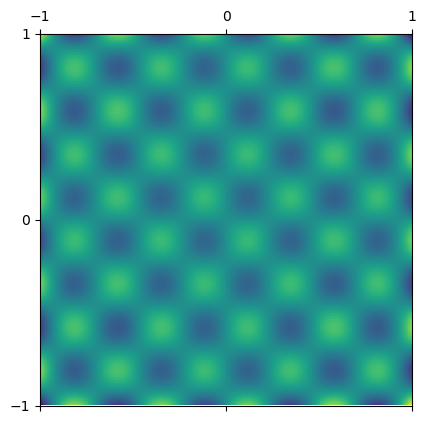

In [196]:
fun.show_waves(x_k)

Below the nodes can be seen from the maximum eigenvector

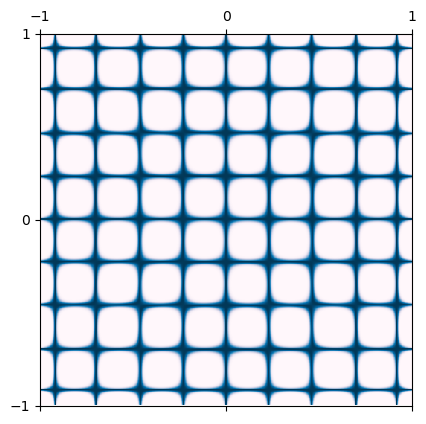

In [180]:
fun.show_nodes(x_k)

It has nodes along a 8x8grid as expected from the project description!

____
c(1)

Below the rayleigh iteration is implemented from Algorithm 4.4 in the book. As we where asked to make it a funciton of an initial shift, one shift is done, before the main loop starts. I have used the same criterion for convergne as above, the norm_2 of the distance between the old and new eigenevctor

In [181]:
def rayleigh_it_my(A, x0, shift_init, its=10000, tol=1e-7, eps=1e-12):
    M = A.copy()
    m, n = M.shape
    x = x0.copy().reshape(-1)
    x = x / np.linalg.norm(x)

    # initial shift
    a_in = M - shift_init * np.eye(m)
    y_in = least_squares_slow(a_in + eps*np.eye(m), x).reshape(-1)
    x = y_in / np.linalg.norm(y_in)

    for i in range(its):
        sig = np.dot(x, np.dot(M, x)) / np.dot(x, x)
        a = M - sig * np.eye(m)
        y = least_squares_slow(a + eps*np.eye(m), x).reshape(-1)
        x_new = y / np.linalg.norm(y, ord =2)
        if np.linalg.norm(x_new - x, ord=2) < tol:
            lam = rayleigh_qt(M, x_new)
            return x_new, lam, i

        x = x_new

    raise RuntimeError("Algorithm did not converge")

In [199]:
results_it = []
for i in range(len(list_of_A)): 
    try:
        test = list_of_A[i]
        centers, radii  = gershgorin(test)
        for j in range(len(centers)):
            x, lam, its = rayleigh_it_my(test, np.ones(test.shape[0]), centers[j] ,eps = 1e-8)
            # print(f"for A{i+1} at center_{j} = {np.round(centers[j],2)}","lam =", np.round(lam,2), "True eigen = ", np.round(list_of_eigvals[i][j],2))
            results_it.append({
                "Matrix": f'A{i+1}',
                "Center": np.round(centers[j],2),
                "Eigenvalue": np.round(lam,2),
                "True eigenvalue": np.round(list_of_eigvals[i][j],2)
            })
    except Exception as e:
        print(f'fail at A{i+1}')
        raise e
    

df_res = pd.DataFrame(results_it)
display(df_res)

,Matrix,Center,Eigenvalue,True eigenvalue
0,A1,1.00,4.00,4.00
1,A1,1.00,4.00,-2.00
2,A2,3.00,4.00,4.00
3,A2,3.00,4.00,2.00
4,A3,1.00,-0.96,12.30
5,A3,3.14,12.30,-4.48
6,A3,2.72,12.30,-0.96
7,A4,1.00,-1.12,16.12
8,A4,5.00,16.12,-1.12
9,A4,9.00,16.12,0.00


_____
d(1)
Power iteration will only give the highest eigenvalue, so it will not give all eigenvalues

d(2)

In [183]:
centers, _ = gershgorin(K)
true_eig = np.linalg.eig(K)[0]
results_K = []

for i in range(len(centers)):
    x, lam, its = rayleigh_it_my(K, np.ones(K.shape[0]), centers[i], eps = 1e-8)
    results_K.append({
    "center" : centers[i],
    "eigenvalue":lam,
    "true eigenvalues":true_eig[i]
        })

df_K = pd.DataFrame(results_K)
display(df_K)
print(len(np.unique(np.round(df_K.eigenvalue,2))))


,center,eigenvalue,true eigenvalues
0,129292.219206,52766.288758,151362.666488
1,103041.439420,93999.614129,93999.614129
2,64967.578727,52766.288758,52766.288758
3,43612.411909,52766.288758,50430.027654
4,36273.751516,36152.369975,36152.369975
5,37990.099373,36152.369975,32779.071084
6,24166.971120,22590.198520,22590.198520
7,11651.158690,11485.212834,13338.622299
8,13865.080461,13338.622299,11485.212834
9,5600.547665,5560.881198,5560.881198


12


In [184]:
centers, radii= gershgorin(K)
list_of_eigs = []
list_of_eig_vevs = []
random_range = np.max(centers) + np.max(radii)
for _ in range(int(1e4)):
    x, lam, its = rayleigh_it_my(K, np.random.rand(K.shape[0]), np.random.uniform(-random_range, random_range), eps = 1e-8)
    lam = np.round(lam,2)
    if lam not in list_of_eigs:
        list_of_eigs.append(lam)
        list_of_eig_vevs.append(x)
    if len(list_of_eigs)==K.shape[0]:
        break


In [185]:
def rayleigh_trial(K, random_range):
    x0 = np.random.rand(K.shape[0])
    shift = np.random.uniform(-random_range, random_range)
    x, lam, its = rayleigh_it_my(K, x0, shift, eps=1e-8)
    lam = np.round(lam, 2)
    return lam, x

centers, radii = gershgorin(K)
random_range = np.max(centers) + np.max(radii)

n_iter = int(1e4)

results = Parallel(n_jobs=-1)(
    delayed(rayleigh_trial)(K, random_range) for _ in range(int(1e4))
)

list_of_eigs = []
list_of_eig_vevs = []
for lam, x in results:
    lam = np.round(lam,3)
    if lam not in list_of_eigs:
        list_of_eigs.append(lam)
        list_of_eig_vevs.append(x)
    if len(list_of_eigs) == K.shape[0]:
        break  


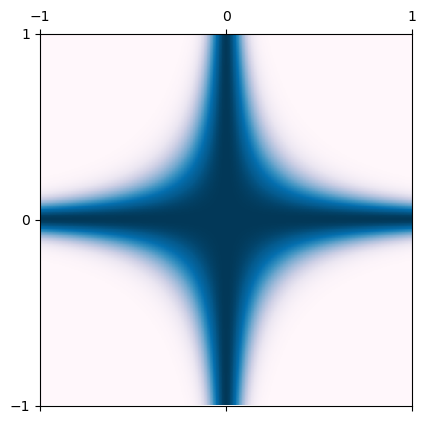

In [186]:
fun.show_nodes(list_of_eig_vevs[np.argmin(list_of_eigs)])

d(3)

In [187]:
a = list_of_eigs.copy()
B = list_of_eig_vevs.copy()
a = np.array(a)
B = np.array(B)
a_s = a[np.argsort(a)]
T_s = np.column_stack(B[np.argsort(a),:])


True


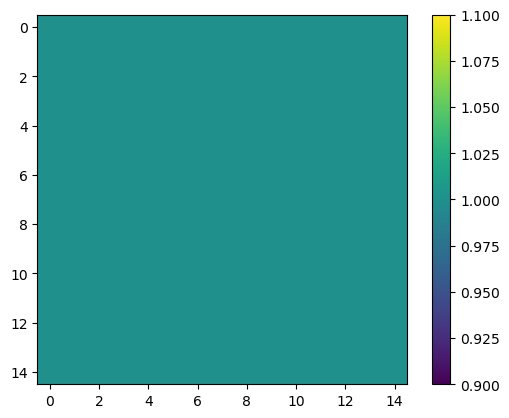

In [188]:
upside_down_V = np.diag(a_s)
plt.imshow(np.isclose(K,T_s @ upside_down_V @ np.linalg.inv(T_s), rtol = 1e-3))
plt.colorbar()
print(np.allclose(K,T_s @ upside_down_V @ np.linalg.inv(T_s), rtol = 1e-3))

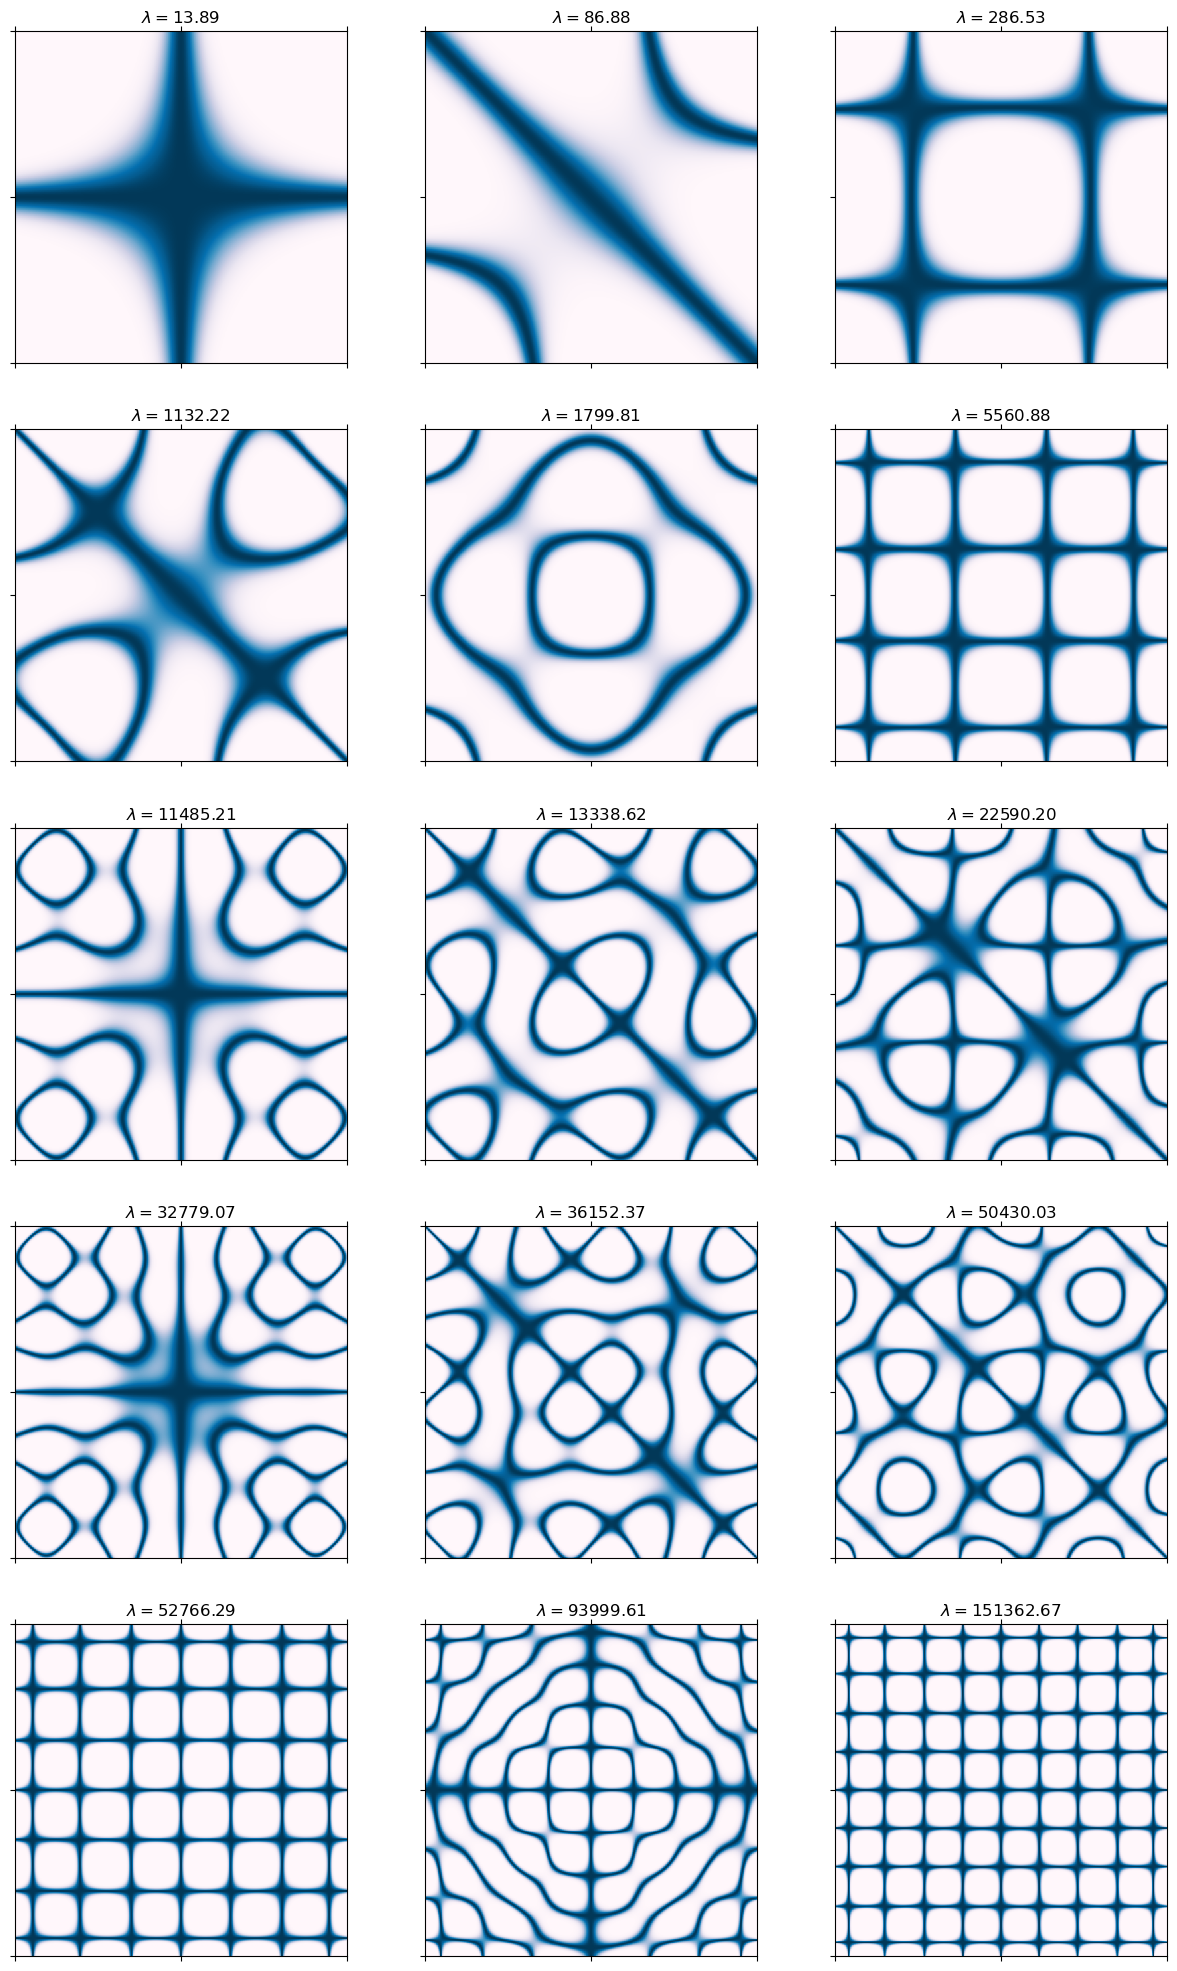

In [189]:
fun.show_all_wavefunction_nodes(T_s, a_s)